In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ignite.metrics import Accuracy, Precision, Recall 
import yfinance as yf
import pandas as pd

In [2]:
data = yf.download(tickers='BTC-USD', period='30d', interval = '2m')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-07-17 00:00:00+01:00,31594.623047,31594.623047,31568.906250,31568.906250,31568.906250,0
2021-07-17 00:02:00+01:00,31597.498047,31626.939453,31597.498047,31626.939453,31626.939453,13203456
2021-07-17 00:04:00+01:00,31615.003906,31615.003906,31615.003906,31615.003906,31615.003906,18847744
2021-07-17 00:06:00+01:00,31627.226562,31627.226562,31591.802734,31591.802734,31591.802734,4063232
2021-07-17 00:08:00+01:00,31609.972656,31609.972656,31600.679688,31600.679688,31600.679688,2064384
...,...,...,...,...,...,...
2021-08-15 10:06:00+01:00,45886.917969,45886.917969,45886.917969,45886.917969,45886.917969,6948864
2021-08-15 10:08:00+01:00,45914.843750,45914.843750,45914.843750,45914.843750,45914.843750,12201984
2021-08-15 10:10:00+01:00,45934.101562,45934.101562,45934.101562,45934.101562,45934.101562,25597952


In [3]:
open = torch.tensor(data['Open'].values, dtype=torch.float32)
high = torch.tensor(data['High'].values, dtype=torch.float32)
low = torch.tensor(data['Low'].values, dtype=torch.float32)
close = torch.tensor(data['Close'].values, dtype=torch.float32)

In [4]:
signal = torch.stack([open, high, low, close])

In [5]:
signal[:, 0]

tensor([31594.6230, 31594.6230, 31568.9062, 31568.9062])

In [6]:
def standardize(array):
    mean = array.mean(dim=1, keepdim=True)
    std = array.std(dim=1, keepdim=True)
    standardized = (array - mean) / std
    return standardized, (mean, std)

In [7]:
a = torch.rand(2, 3)
standardize(a)

(tensor([[ 0.4776, -1.1493,  0.6717],
         [-0.8818,  1.0865, -0.2047]]),
 (tensor([[0.6412],
          [0.4761]]),
  tensor([[0.1841],
          [0.2012]])))

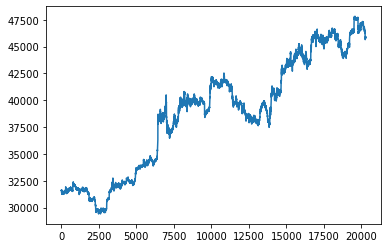

In [8]:
plt.plot(open)

In [9]:
def chunkize(series, chunk_size):
    n_chunks = len(series) - chunk_size
    chunked = []
    for i in range(n_chunks):
        chunk, _ = standardize(series[i: i+chunk_size])
        data = chunk[:int(len(chunk)*.75)]
        target = chunk[int(len(chunk)*.75):]
        chunked.append([data, target])
    
    return chunked
        

In [10]:
chunksize = 180
chunked = chunkize(signal.reshape(-1, 4), chunksize)

In [11]:
class Signal(Dataset):
    
    def __init__(self, dataset, phase=None):
        
        if phase == 'train':
            start = 0
            end = int(len(dataset)*.5)
        if phase == 'val':
            start = int(len(dataset)*.5)
            end = int(len(dataset)*.75)
        if phase == 'test':
            start = int(len(dataset)*.75)
            end = len(dataset)
        else:
            start = 0
            end = len(dataset)
    
        self.dataset = dataset[start:end]


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data = self.dataset[idx][0]
        target = self.dataset[idx][1]
            
        return data, target

In [12]:
train_set = Signal(chunked, 'train')
val_set = Signal(chunked, 'val')
test_set = Signal(chunked, 'test')

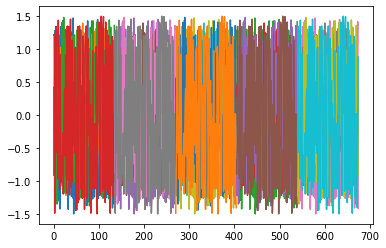

In [13]:
for idx, sample in enumerate(train_set.dataset):
    if idx == 5:
        break
    plt.plot(torch.arange(idx*len(sample[0]), idx*len(sample[0])+len(sample[0])), sample[0])
    #plt.xlim(50, 1500)

In [14]:
len(train_set)

20102

In [15]:
train_set[0][0].__len__()

135

In [16]:
# hyperparams
batch_size = 128
learning_rate = 0.9
num_epochs = 30

In [17]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [18]:
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_seq_size):
        super(LSTM1, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dropout=.2)

        self.fc1 = nn.Linear(hidden_size, 4*out_seq_size)
    
    def forward(self,x):
        batch_size = x.shape[0]

        x, _ = self.lstm(x)
        x = x[:, -1, :]
    
        
        x = self.fc1(x)
        x= x.reshape(batch_size, -1, 4)
        return x

In [19]:
model = LSTM1(4, 50, 4, 45)

In [20]:
if torch.cuda.is_available:
    device = 'cuda'
else:
    device = 'cpu'

model.to(device)

LSTM1(
  (lstm): LSTM(4, 50, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=50, out_features=180, bias=True)
)

In [31]:
model(torch.rand(1, 100, 4).to(device)).shape

torch.Size([1, 45, 4])

In [23]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_fn = torch.nn.MSELoss()

In [24]:
total_progress = tqdm(total=num_epochs, desc='Total progress')
epoch_losses = []

for epoch in range(num_epochs):


    model.train()
    epoch_progress = tqdm(total=len(train_loader), desc=f'Epoch {epoch}', leave=False)
    for data, target in train_loader:

        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = torch.squeeze(model(data))
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_progress.update()
    epoch_progress.close()
    
    model.eval()
    val_progress = tqdm(total=len(val_loader), desc=f'Epoch {epoch}. Validating...', leave=False)
    val_losses = []
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = torch.squeeze(model(data))
        loss = loss_fn(output, target)
        val_losses.append(loss.item())
        val_progress.update()
    val_progress.close()    
        
    mean_val_loss = torch.mean(torch.tensor(val_losses))
    epoch_losses.append(mean_val_loss)

    if mean_val_loss == min(epoch_losses):
        torch.save(model, 'min_loss.pt')
        
    scheduler.step(mean_val_loss)
    
    print(f"Val loss {epoch}: {epoch_losses[-1]}")

    total_progress.update()

total_progress.close()

Val loss 0: 0.7500472068786621


Val loss 1: 0.7499383091926575


Val loss 2: 0.7499215006828308


Val loss 3: 0.7499343156814575


Val loss 4: 0.7499355673789978


Val loss 5: 0.7499294281005859


Val loss 6: 0.7499174475669861


Val loss 7: 0.7499327659606934


Val loss 8: 0.7499212622642517


Val loss 9: 0.7499263882637024


KeyboardInterrupt: 

In [25]:
test_signal = signal[:, int(len(signal)*.75):]
# plt.plot(test_signal)

In [26]:
model = torch.load('min_loss.pt')
model.to(device)

LSTM1(
  (lstm): LSTM(4, 50, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=50, out_features=180, bias=True)
)

In [27]:
initial_data = test_signal[:, :chunksize-1]
initial_data.shape


torch.Size([4, 179])

In [38]:
model.eval()
initial_data = test_signal[:, :chunksize-1]


def prepare(data):
    return data.reshape(1, -1, 4).to(device)


preds = []

num_predictions = 200
progress = tqdm(total=num_predictions, desc='Progress')
for i in range(num_predictions):
    standardized, (mean, std) = standardize(initial_data)
    pred = model(prepare(standardized))
    pred *= std.reshape(-1).to(device)
    pred += mean.reshape(-1).to(device)
    preds.append(pred.squeeze()[0])
    initial_data = test_signal[:, i:chunksize-1 + i]
    progress.update()
    
progress.close()

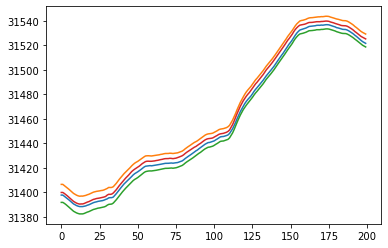

In [39]:
preds = torch.stack(preds).reshape(-1, 4).detach().to('cpu')
plt.plot(preds)

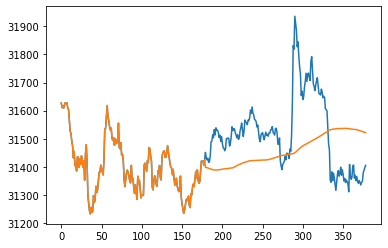

In [40]:
plt.plot(test_signal[:, :chunksize-1+num_predictions][0])

plt.plot(torch.cat((test_signal[:, :chunksize-1][0], preds[:, 0])))